# Linear Support Vector Machine Regression with Stochastic Gradient Descent

# References

* http://leon.bottou.org/publications/pdf/compstat-2010.pdf
* http://research.microsoft.com/pubs/192769/tricks-2012.pdf
* http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=1257413&tag=1
* http://www.sciencedirect.com/science/article/pii/S0305048301000263
* http://link.springer.com/book/10.1007/978-3-642-35289-8

In [15]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

%load_ext version_information
%version_information deap, matplotlib, numpy, pandas, pymc3, seaborn, sklearn, theano

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The version_information extension is already loaded. To reload it, use:
  %reload_ext version_information


Software,Version
Python,3.5.1 64bit [GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
IPython,4.1.2
OS,Linux 3.13.0 86 generic x86_64 with debian jessie sid
deap,1.0
matplotlib,1.5.1
numpy,1.10.4
pandas,0.18.0
pymc3,3.0
seaborn,0.7.0
sklearn,0.17.1


In [16]:
from nsga2 import *
from IPython.display import display
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import random
import seaborn as sns
from sklearn import linear_model
from sklearn import preprocessing as preproc
from sklearn import svm
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error as mse, accuracy_score as acc_scr, mean_absolute_error as mae

np.set_printoptions(threshold=np.nan)
sns.set()

In [17]:
path = '../btc-data/BTC_LOB_techind_10s.csv'
data10s = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_30s.csv'
data30s = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_60s.csv'
data1m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_300s.csv'
data5m = pd.read_csv(path, index_col = 0, parse_dates = True)

path = '../btc-data/BTC_LOB_techind_600s.csv'
data10m = pd.read_csv(path, index_col = 0, parse_dates = True)

datas = [data10s, data30s, data1m, data5m, data10m]

In [18]:
def directional_symmetry(act, pred):
    act_ticks = list(map(lambda x: 1 if x >= 0 else 0, act.values))
    pred_ticks = list(map(lambda x: 1 if x >= 0 else 0, pred))
    d = list(map(lambda t: t[0] == t[1], zip(act_ticks, pred_ticks)))
    
    return np.sum(d) / len(act_ticks)

In [19]:
#def filter_features(mask):
#    return list(map(lambda t: t[1], filter(lambda t: t[0], zip(mask, FEATURES))))

def fitness_fun(model):
    method, indiv, dataset = model
    
    X_train, X_valid, y_train, y_valid = dataset
    
    #print(X_train.columns)
    
    # Train the learner on the training data
    # and evaluate the performance by the test data
    
    if indiv[0] <= 0:
        indiv[0] = 0.0001
        
    if indiv[1] <= 0:
        indiv[1] = 0.002
        
    method.alpha = indiv[0]
    method.eta0 = indiv[1]
    
    method.fit(X_train, y_train)
    
    pred = method.predict(X_valid)
    rmse = np.sqrt(mse(y_valid, pred))
    r2 = method.score(X_valid, y_valid)
    dir_sym = directional_symmetry(y_valid, pred)
    
    return dir_sym, rmse

def nsga2_feat_sel(method, gen_num, indiv_num, dataset):
    creator.create("FitnessMulti", base.Fitness, weights = (1.0, -1.0))
    creator.create("Individual", list, fitness=creator.FitnessMulti)
    toolb.register('alpha', random.uniform, 1e-8, 0.01)
    toolb.register('eta0', random.uniform, 0.0001, 0.01)
    toolb.register('individual', tools.initCycle, creator.Individual, 
                   (toolb.alpha, toolb.eta0), n = 1)
    toolb.register('population', tools.initRepeat, list, toolb.individual, n = indiv_num)
    toolb.register('evaluate', fitness_fun)
    toolb.register('mate', tools.cxUniform, indpb = 0.1)
    toolb.register('mutate', tools.mutGaussian, mu = 0.0001, sigma = 0.001, indpb = 0.1)
    toolb.register('select', tools.selNSGA2)

    population = toolb.population()
    fits = map (toolb.evaluate, map(lambda x: (method, x, dataset), population))

    hof = tools.HallOfFame(1)

    for fit, ind in zip(fits, population):
        ind.fitness.values = fit

    best = np.ndarray((gen_num, 2))
    top_RMSE = []

    for gen in range(gen_num):
        offspring = algorithms.varOr(population, toolb, lambda_ = indiv_num, cxpb = 0.55, mutpb = 0.15)
        hof.update(offspring)

        fits = map (toolb.evaluate, map(lambda x: (method, x, dataset), offspring))

        for fit, ind in zip(fits, offspring):
            ind.fitness.values = fit

        population = toolb.select(offspring + population, k = indiv_num)

        best[gen] = (hof[0].fitness.values)
        top_RMSE = hof[0]

    chromosome = hof[0]
    #selected_features = list(map(lambda t: t[1], filter(lambda t: t[0], zip(hof[0], CHARTS[1:]))))
    
    return best, method, chromosome

In [20]:
def feature_selection(gen_num, indiv_num, model, dataset):
    results = nsga2_feat_sel(model, gen_num, indiv_num, dataset)
    
    best_model = results[1]
    chromosome = results[2]

    print ('Scores', results[0], '\n')
    print ('Chromosome: ', chromosome, '\n')
    
    # Create dataframes from the metrics
    results_df = pd.DataFrame(results[0], columns = ['DS', 'RMSE'])
    results_df.insert(0, 'Generation', results_df.index)
    
    # Plot the best individuals of each generation based on the metrics
    g = sns.PairGrid(results_df, y_vars=['DS', 'RMSE'], x_vars = 'Generation', size=7, aspect = 2.5)
    g.map(plt.plot)
    
    return best_model, chromosome

In [21]:
def evaluate(data, features):
    X, y = data[features], data['DELTAP'].copy()
    
    calib_dates = X.index[:int(0.2*len(X))]
    valid_dates = X.index[int(0.2*len(X)):int(0.3*len(X))]
    train_dates = X.index[int(0.3*len(X)):int(0.7*len(X))]
    test_dates = X.index[int(0.7*len(X)):]
    
    X_calib = X[calib_dates[0]:calib_dates[-1]]
    y_calib = y[calib_dates[0]:calib_dates[-1]]
    
    X_valid = X[valid_dates[0]:valid_dates[-1]]
    y_valid = y[valid_dates[0]:valid_dates[-1]]

    X_train = X[train_dates[0]:train_dates[-1]]
    y_train = y[train_dates[0]:train_dates[-1]]
    
    X_test = X[test_dates[0]:test_dates[-1]]
    y_test = y[test_dates[0]:test_dates[-1]]
    
    scaler = preproc.StandardScaler()
    for df in X_calib.columns.tolist():
        scaler.fit(X_calib[df].reshape(-1,1))
        X_calib[df] = scaler.transform(X_calib[df].reshape(-1,1))
        X_valid[df] = scaler.transform(X_valid[df].reshape(-1,1))
        X_train[df] = scaler.transform(X_train[df].reshape(-1,1))
        X_test[df] = scaler.transform(X_test[df].reshape(-1,1))
        
    sgd = linear_model.SGDRegressor(shuffle = True, penalty = 'l2', epsilon = 0,
                                    loss = 'epsilon_insensitive',
                                    n_iter = np.ceil(10**6 / len(X_train)))
    
    dataset = X_calib, X_valid, y_calib, y_valid
    
    model = feature_selection(30, 15, sgd, dataset)
    best_model, chromosome = model
    
    best_model.alpha = chromosome[0]
    best_model.eta0 = chromosome[1]
    
    for i in range(len(X_train)):
        x = X_train.ix[i]
        y = y_train.ix[i]
        best_model.partial_fit(x.reshape(1,-1), y.ravel(1,))
    
    pred = []
    
    for i in range(len(X_test)):
        x = X_test.ix[i]
        y = y_test.ix[i]
        pred.append(best_model.predict(x.reshape(1,-1)))
        best_model.partial_fit(x.reshape(1,-1), y.ravel(1,))
    
    #pred = best_model.predict(X_test)
    
    dr = DummyRegressor(strategy='mean')
    dr.fit(X_train, y_train)
    pred_base = dr.predict(X_test)
    rmse_base = np.sqrt(mse(y_test, pred_base))

    print('\n\nResults')
    print('==============================================\n')
    R2_test = best_model.score(X_test, y_test)
    R2_train = best_model.score(X_train, y_train)
    print('Training set R2: ', R2_train, ', Test set R2: ', R2_test)
    rmse_test = np.sqrt(mse(y_test, pred))
    rmse_train = np.sqrt(mse(y_train, best_model.predict(X_train)))
    print('Training set RMSE: ', rmse_train, ', Test set RMSE: ', rmse_test)
    mae_test = mae(y_test, pred)
    mae_train = mae(y_train, best_model.predict(X_train))
    print('Training set MAE: ', mae_train, ', Test set MAE: ', mae_test)
    print('Training hit rate: ',directional_symmetry(y_train, best_model.predict(X_train)),
          'Test hit rate: ', directional_symmetry(y_test, pred), '\n')
    print('Baseline hit rate: ', directional_symmetry(y_test, pred_base))
    print('Baseline RMSE: ', rmse_base)
    print('==============================================\n\n')

    plt.figure(figsize = (20,10))
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    #plt.xlim('2016-04-24 17', '2016-04-24 20')
    #plt.ylim(-0.1,0.1)
    plt.legend()
    
    plt.figure(figsize = (20,10))
    plt.plot(y_test.index, y_test, label = 'Actual Prices')
    plt.plot(y_test.index, pred, label = 'Predicted Prices')
    plt.xlim('2016-04-24 17', '2016-04-24 20')
    plt.ylim(-1,1)
    plt.legend()

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.54272915  0.1173541 ]
 [ 0.54272915  0.1173541 ]
 [ 0.62183169  0.11733428]
 [ 0.62183169  0.11733428]
 [ 0.67875603  0.11733421]
 [ 0.67875603  0.11733421]
 [ 0.67875603  0.11733421]
 [ 0.67875603  0.11733421]
 [ 0.67875603  0.11733421]
 [ 0.67875603  0.11733421]
 [ 0.69591852  0.11741228]
 [ 0.69591852  0.11741228]
 [ 0.69591852  0.11741228]
 [ 0.69591852  0.11741228]
 [ 0.69591852  0.11741228]
 [ 0.70972127  0.11731957]
 [ 0.70972127  0.11731957]
 [ 0.70972127  0.11731957]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]
 [ 0.71570373  0.11732178]] 

Chromosome:  [0.006398859471972887, 0.002339442844899867] 



Results

Training set R2:  9.17542277734e-05 , Test set R2:  0.000668524536537
Training set RMSE:  0.110187318541 , Te

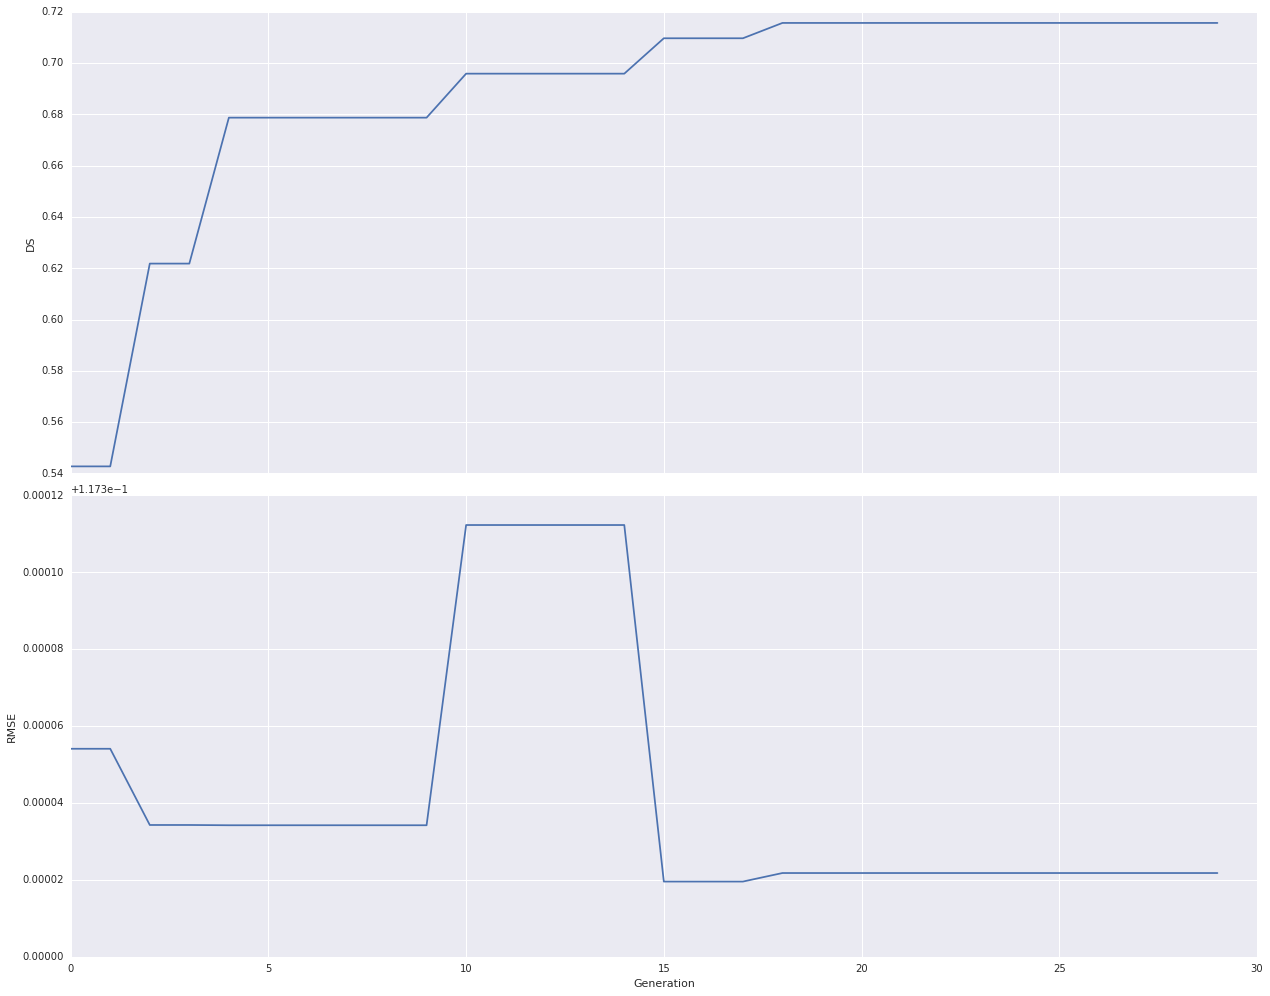

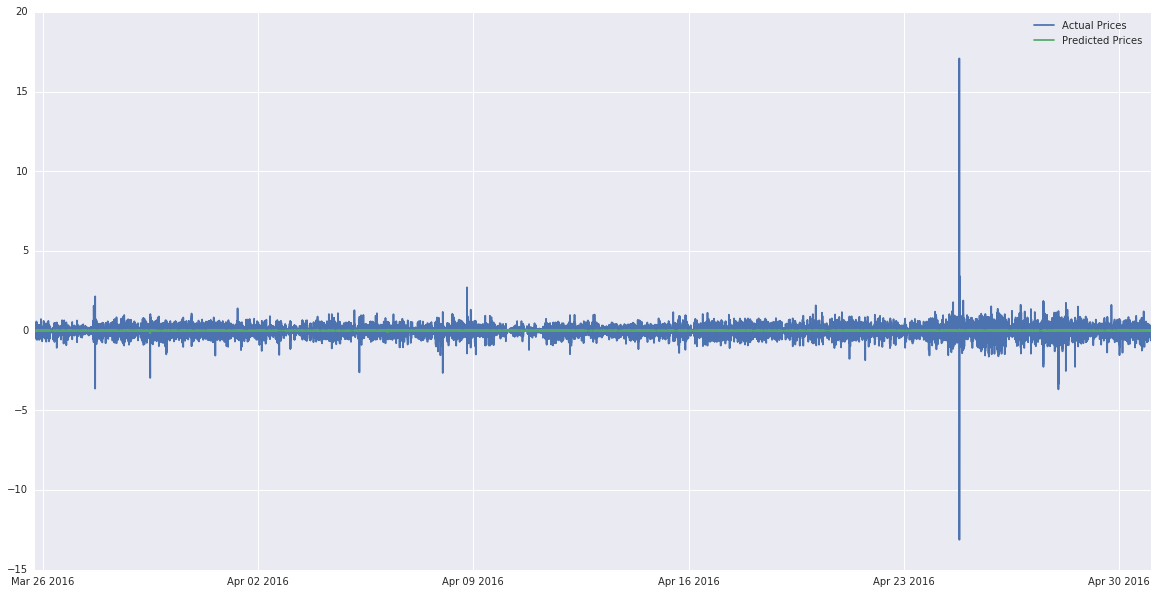

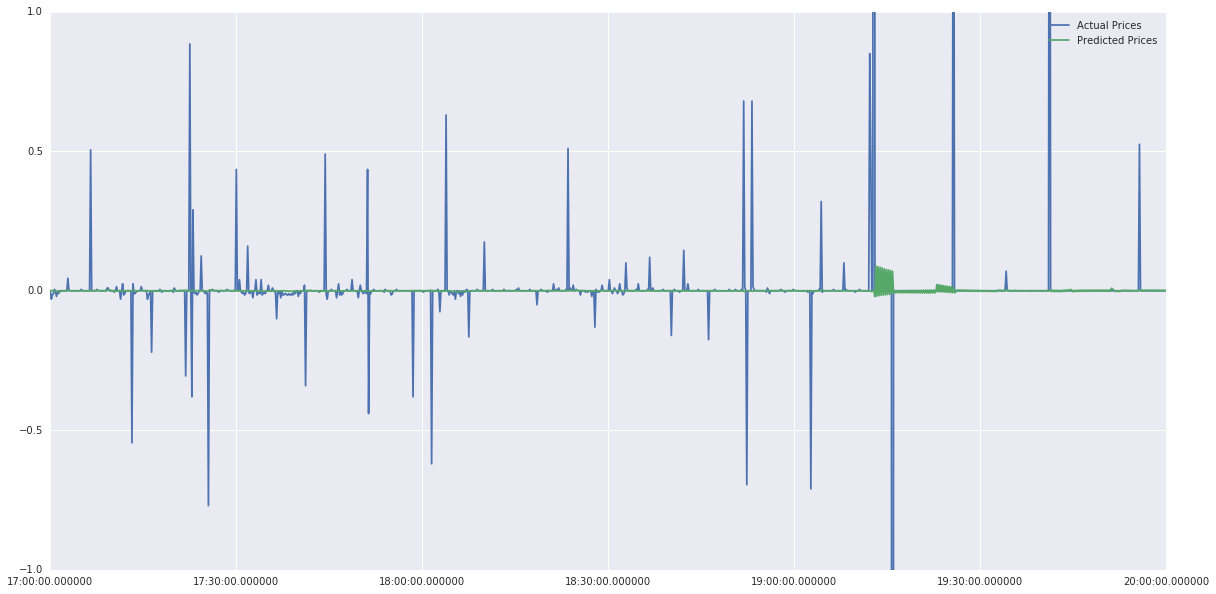

In [22]:
features = ['B-ASPREAD', 'K360', 'K180',
            'MOM60', 'ROC60', 'LWR360',
            'LWR180', 'ADOSC360', 'ADOSC180',
            'DISP360', 'DISP180', 'DISP60',
            'OSCP60-180', 'RSI60']

evaluate(datas[0].copy(), features)

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.60203729  0.19301662]
 [ 0.60957643  0.19298181]
 [ 0.60957643  0.19298181]
 [ 0.63302831  0.19296913]
 [ 0.63302831  0.19296913]
 [ 0.63302831  0.19296913]
 [ 0.63302831  0.19296913]
 [ 0.63302831  0.19296913]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]
 [ 0.6382942   0.19292912]] 

Chromosome:  [0.007556683795987297, 0.006554691725444683] 



Results

Training set R2:  -0.00526132226928 , Test set R2:  -0.00156622111488
Training set RMSE:  0.176088164402 , Te

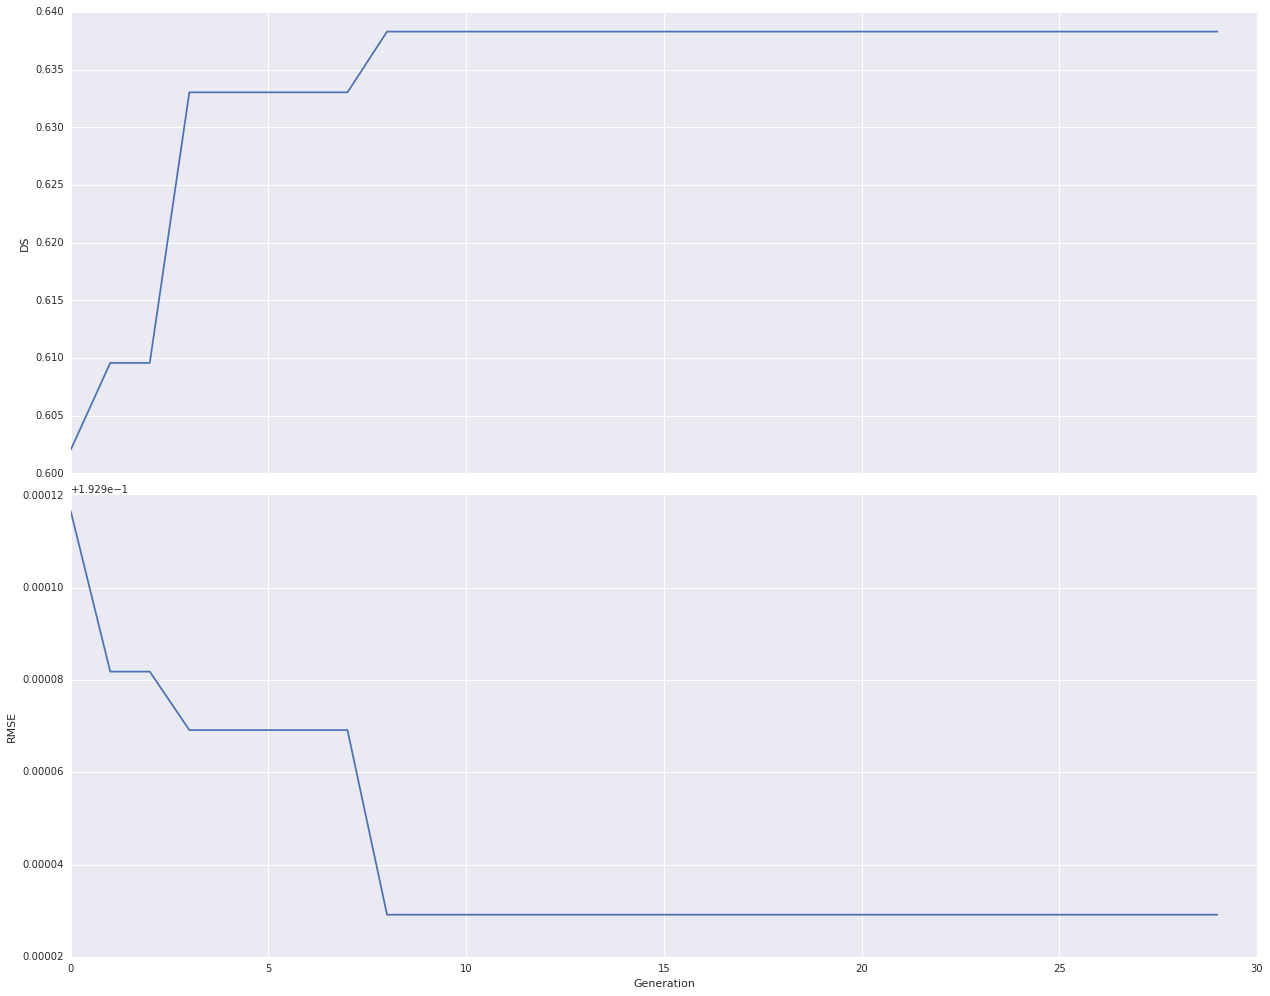

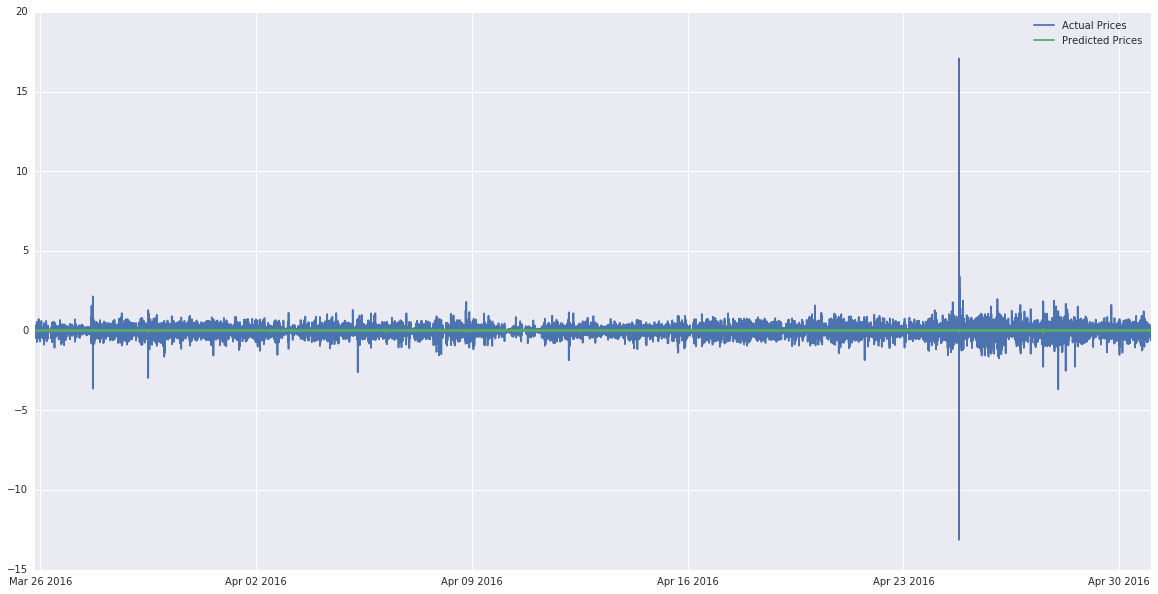

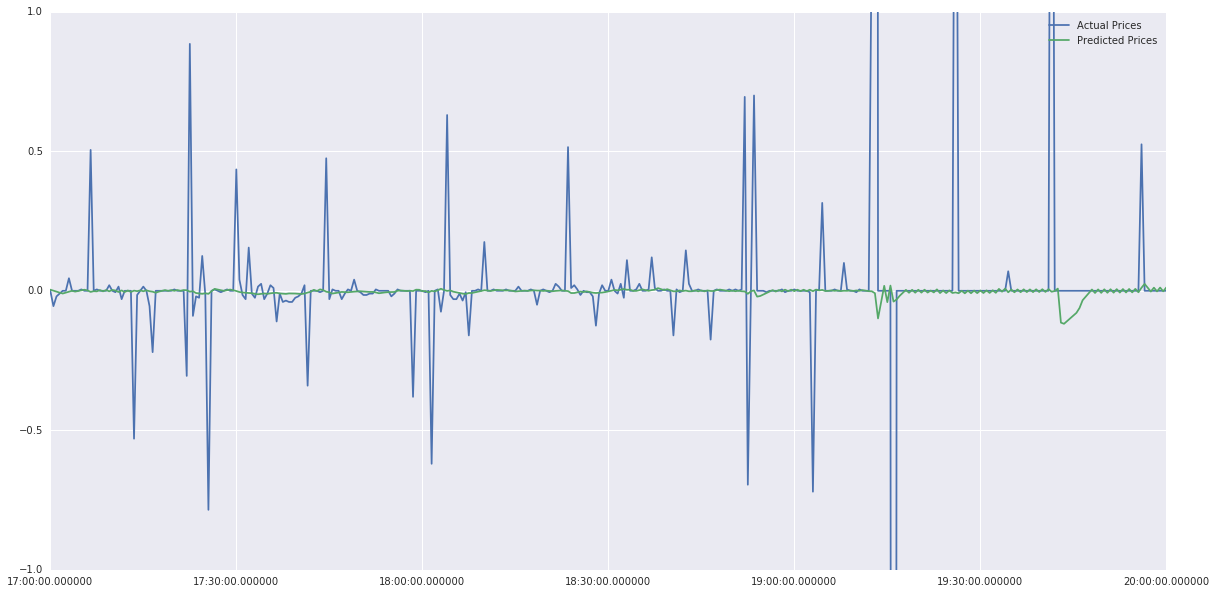

In [23]:
features = ['B-ASPREAD', 'K360', 'K180', 'K60', 'MOM60', 'ROC60',
            'LWR360', 'LWR180', 'LWR60', 'ADOSC360', 'ADOSC180',
            'ADOSC60', 'DISP360', 'RSI60'] 

evaluate(datas[1].copy(), features)

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.54676134  0.26012096]
 [ 0.54676134  0.26012096]
 [ 0.54676134  0.26012096]
 [ 0.57227803  0.26020194]
 [ 0.57227803  0.26020194]
 [ 0.58290036  0.26010035]
 [ 0.58290036  0.26010035]
 [ 0.58290036  0.26010035]
 [ 0.58290036  0.26010035]
 [ 0.58290036  0.26010035]
 [ 0.58290036  0.26010035]
 [ 0.58290036  0.26010035]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.58555594  0.26000106]
 [ 0.59814109  0.25996182]
 [ 0.59814109  0.25996182]
 [ 0.59814109  0.25996182]] 

Chromosome:  [0.0011565909549293505, 0.008094641014436637] 



Results

Training set R2:  -0.0114011209015 , Test set R2:  -0.00592000300389
Training set RMSE:  0.235860263512 , Te

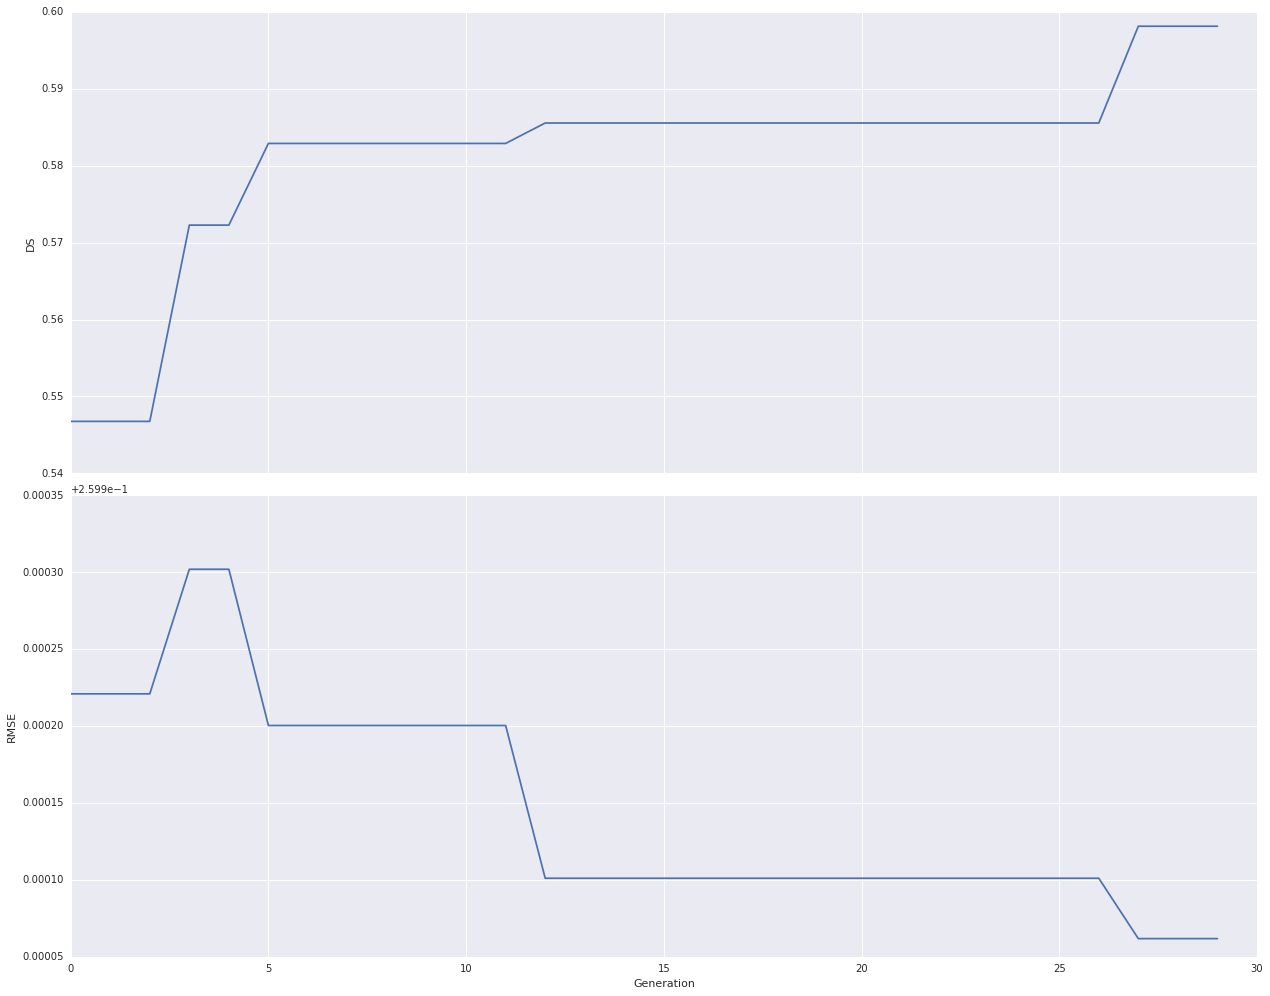

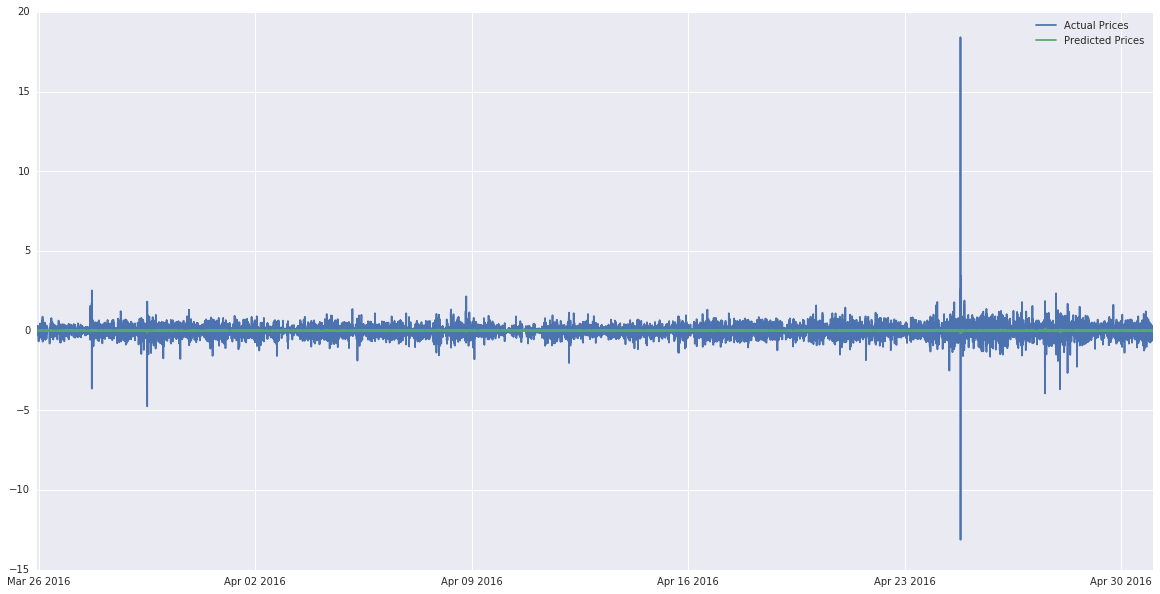

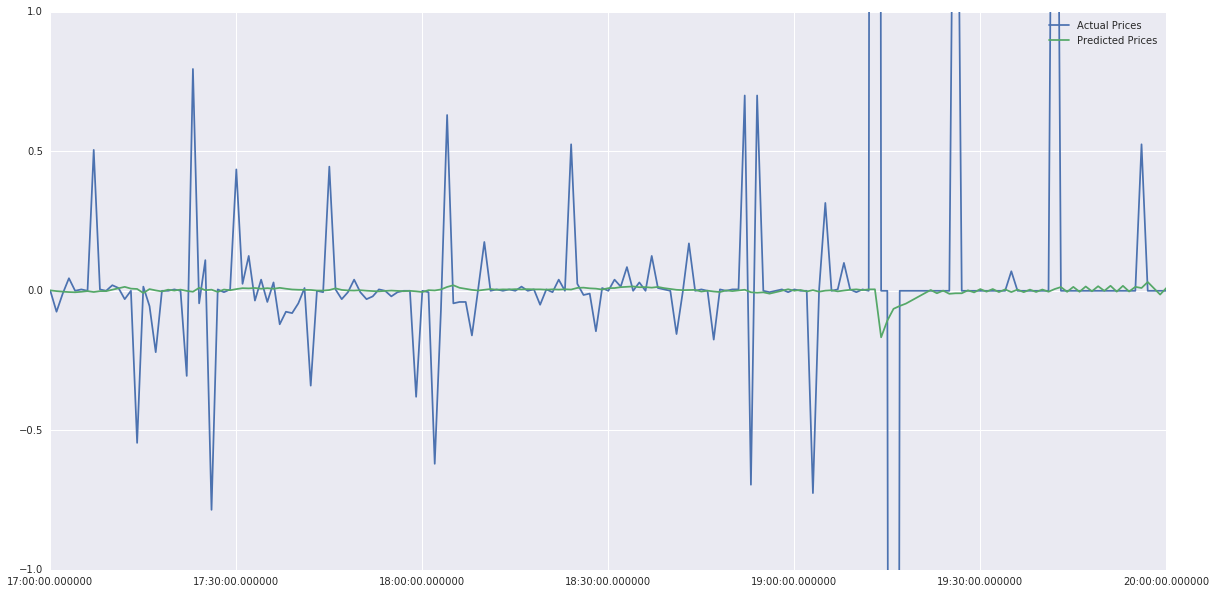

In [24]:
features = ['B-ASPREAD', 'K360', 'K180', 'K60', 'MOM180', 'MOM60', 'ROC360',
            'ROC60', 'LWR360', 'LWR180', 'LWR60', 'ADOSC360',
            'ADOSC180', 'ADOSC60', 'DISP360', 'OSCP180-360', 'RSI60']

evaluate(datas[2].copy(), features)

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.54174067  0.52261428]
 [ 0.54440497  0.52344952]
 [ 0.5500296   0.5222098 ]
 [ 0.55239787  0.52313026]
 [ 0.55239787  0.52313026]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]
 [ 0.55861456  0.5224796 ]] 

Chromosome:  [0.0024269713731346907, 0.009123325958120786] 



Results

Training set R2:  -0.0330515165027 , Test set R2:  -0.0083976428223
Training set RMSE:  0.490532275238 , Tes

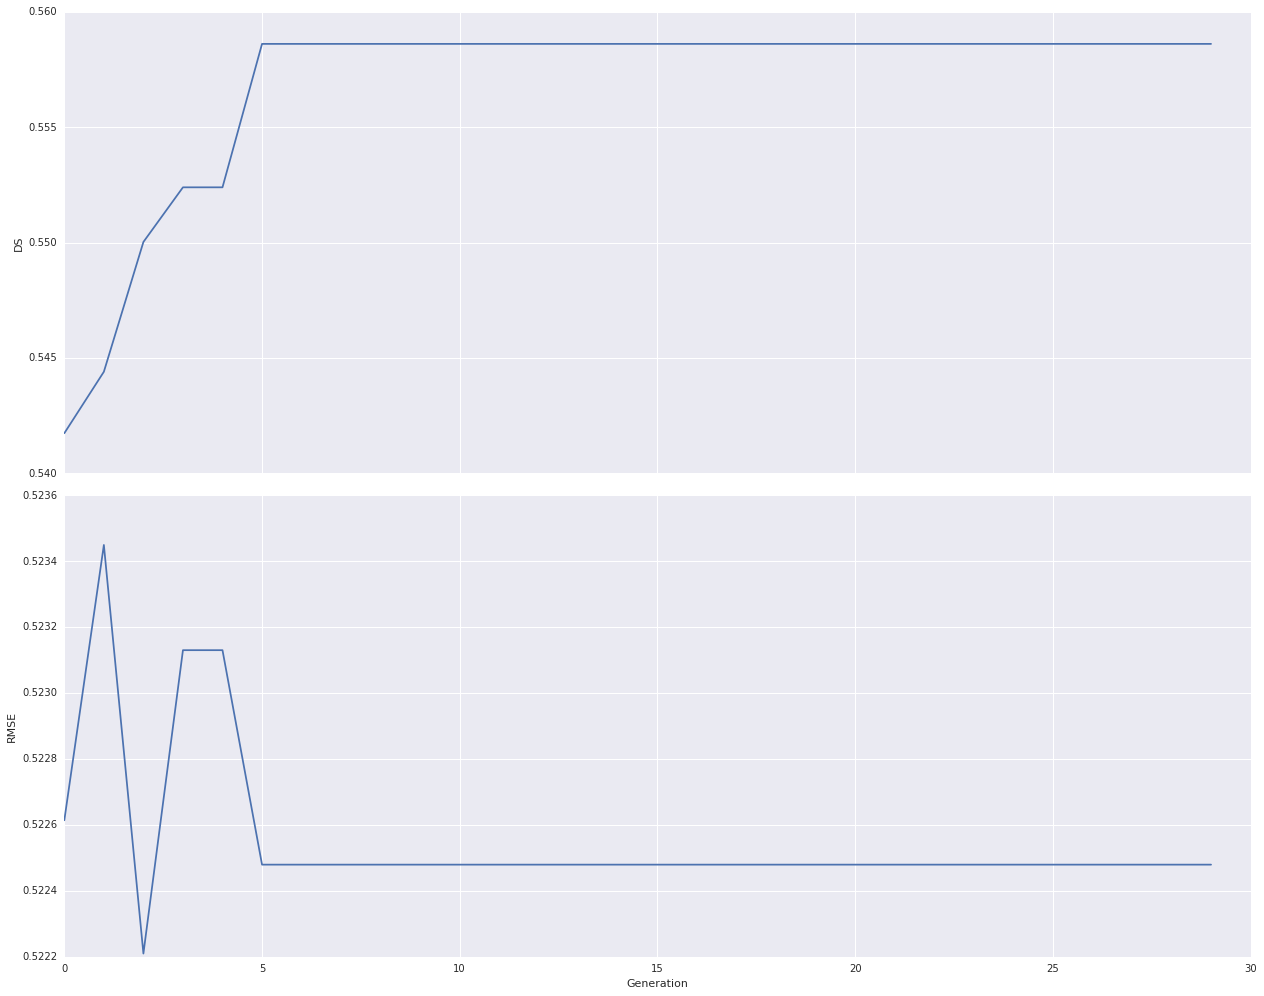

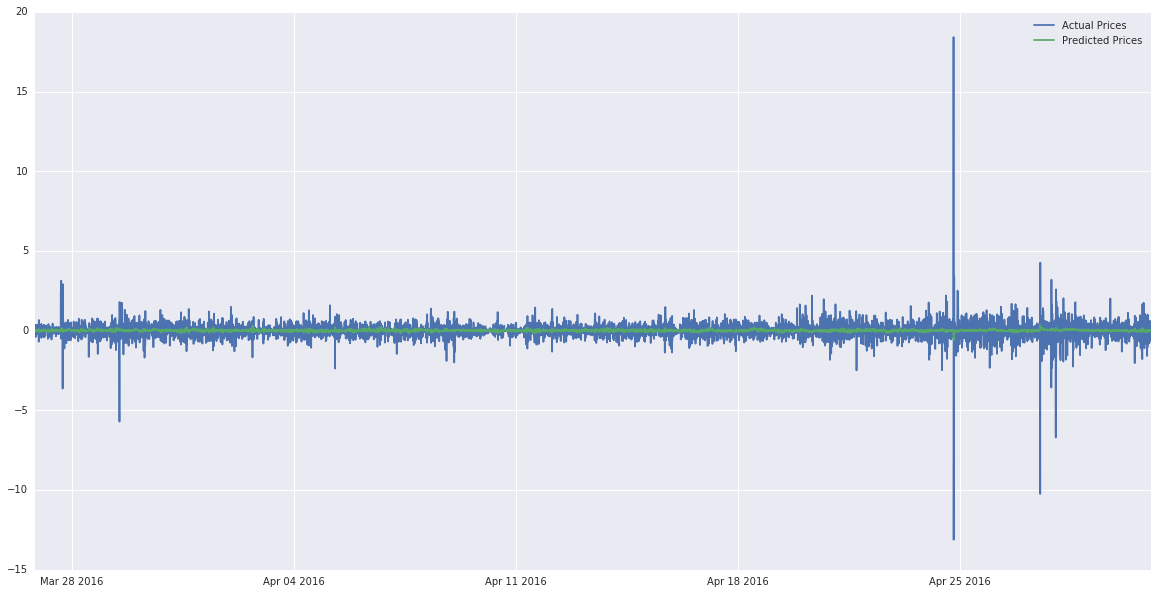

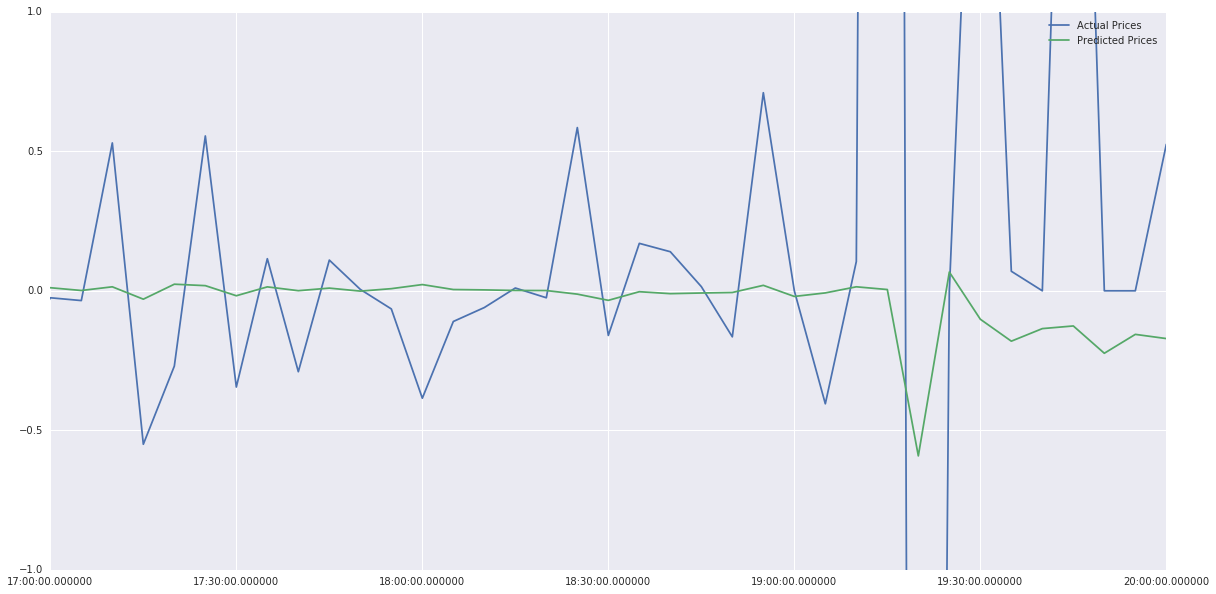

In [25]:
features = ['B-ASPREAD', 'K360', 'K180', 'K60', 'D360', 'D180', 'sD360',
            'sD180', 'sD60', 'MOM180', 'MOM60', 'ROC360', 'LWR360',
            'LWR180', 'LWR60', 'ADOSC360', 'ADOSC180', 'ADOSC60', 'DISP60', 
            'OSCP180-360', 'RSI360', 'RSI60', 'CCI360', 'CCI180', 'CCI60']

evaluate(datas[3].copy(), features)

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

Scores [[ 0.58409786  0.62166298]
 [ 0.58409786  0.62166298]
 [ 0.58409786  0.62166298]
 [ 0.58409786  0.62166298]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58593272  0.6209875 ]
 [ 0.58715596  0.62088237]
 [ 0.58715596  0.62088237]
 [ 0.58715596  0.62088237]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]
 [ 0.58899083  0.62091471]] 

Chromosome:  [0.009082419470217918, 0.0033028532377348155] 



Results

Training set R2:  0.00452253879429 , Test set R2:  0.0039872259687
Training set RMSE:  0.640054119972 , Test

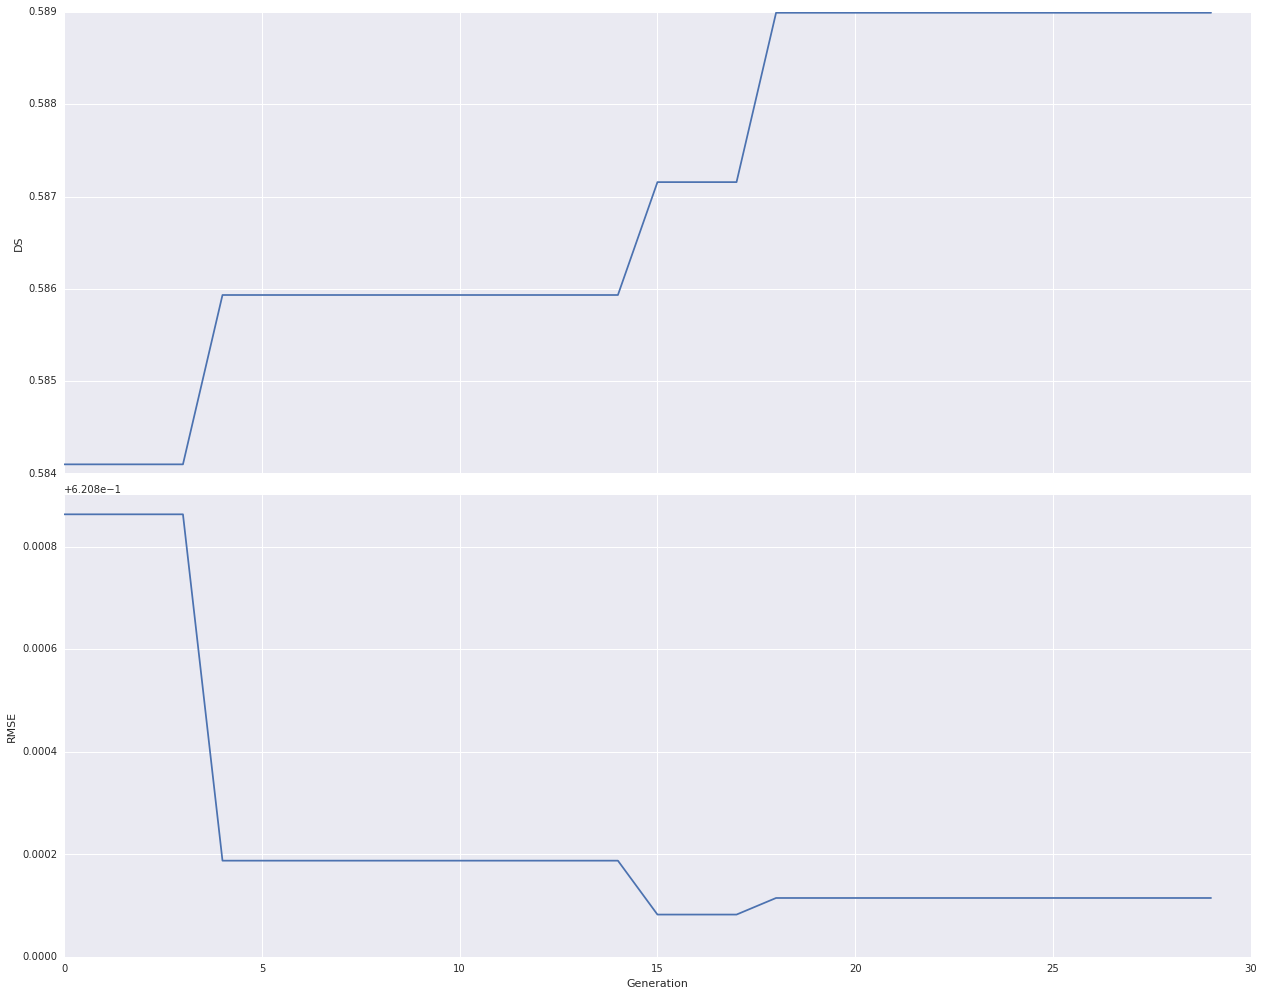

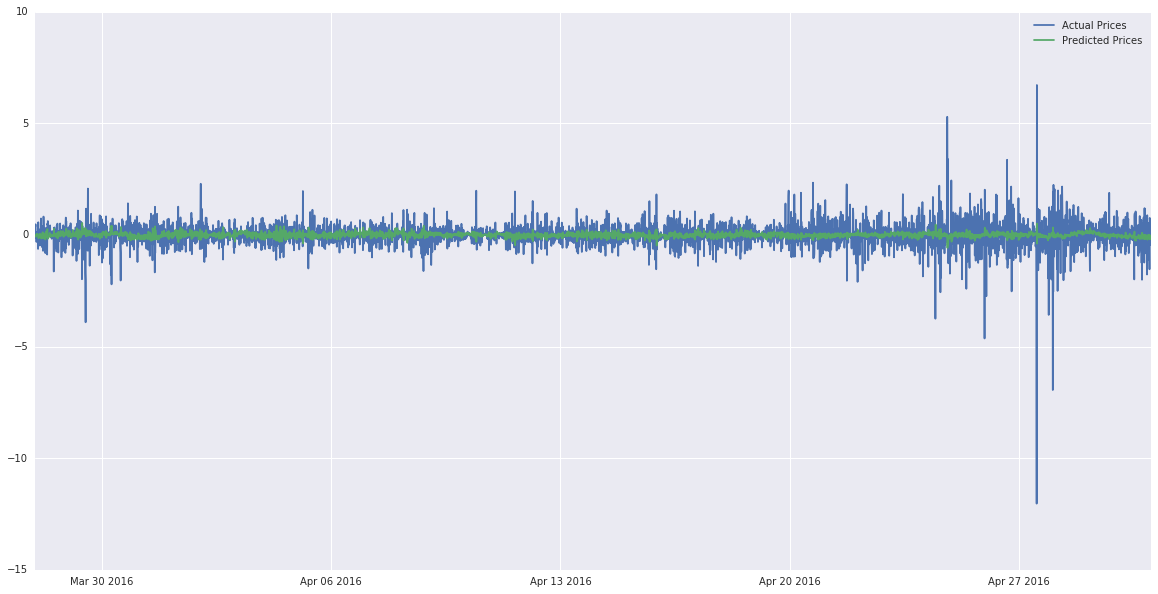

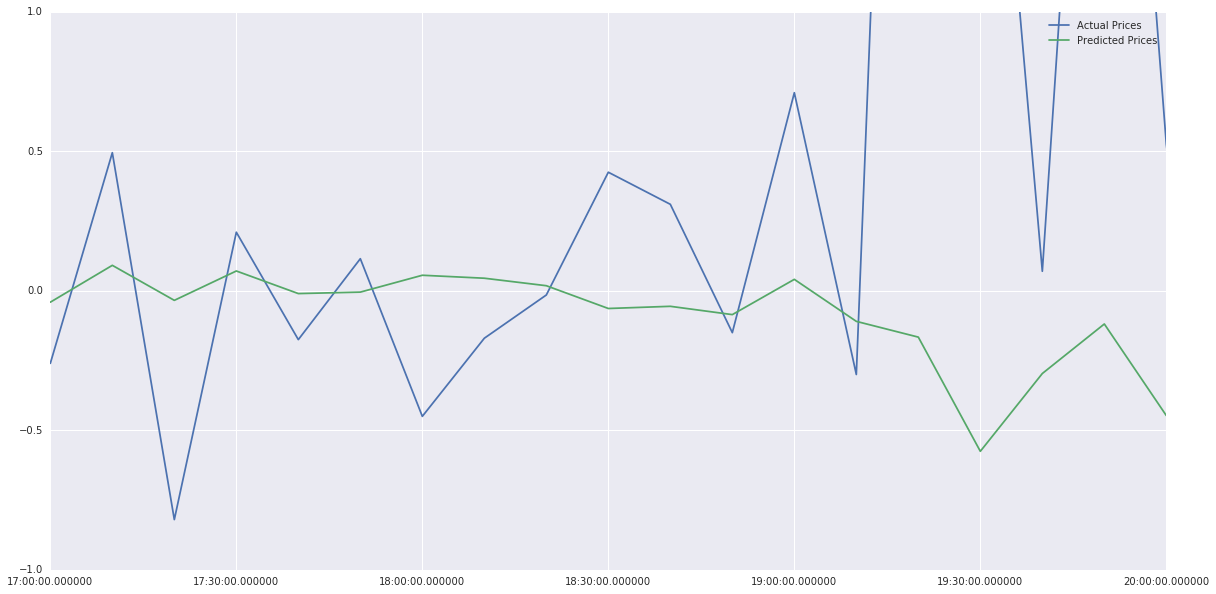

In [26]:
features = ['B-ASPREAD', 'K360', 'K180', 'K60',
            'D180', 'D60', 'sD360', 'sD180', 'MOM360',
            'MOM180', 'ROC360', 'ROC180', 'ROC60', 'LWR360',
            'LWR180', 'LWR60', 'ADOSC360', 'ADOSC180', 'ADOSC60',
            'DISP360', 'DISP180', 'DISP60', 'OSCP180-360', 'OSCP60-180',
            'RSI360', 'RSI60', 'CCI180', 'CCI60'] 

evaluate(datas[4].copy(), features)

In [27]:
features = ['B-ASPREAD', 'K360', 'K180', 'K60',
            'D180', 'D60', 'sD360', 'sD180', 'MOM360',
            'MOM180', 'ROC360', 'ROC180', 'ROC60', 'LWR360',
            'LWR180', 'LWR60', 'ADOSC360', 'ADOSC180', 'ADOSC60',
            'DISP360', 'DISP180', 'DISP60', 'OSCP180-360', 'OSCP60-180',
            'RSI360', 'RSI60', 'CCI180', 'CCI60']

X, y = data10m[features].copy(), data10m['DELTAP'].copy()

train_dates = X.index[int(0.3*len(X)):int(0.7*len(X))]
test_dates = X.index[int(0.7*len(X)):]

X_train = X[train_dates[0]:train_dates[-1]]
y_train = y[train_dates[0]:train_dates[-1]]
    
X_test = X[test_dates[0]:test_dates[-1]]
y_test = y[test_dates[0]:test_dates[-1]]

scaler = preproc.StandardScaler()
for df in X_train.columns.tolist():
    scaler.fit(X_train[df].reshape(-1,1))
    X_train[df] = scaler.transform(X_train[df].reshape(-1,1))
    X_test[df] = scaler.transform(X_test[df].reshape(-1,1))

clf = svm.SVR(C = len(X_train)/0.007777643324327109, epsilon=0, cache_size=10000, max_iter = 10000)
clf.fit(X_train, y_train)

pred = clf.predict(X_test)

print(directional_symmetry(y_test, pred))

/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/dl3913/anaconda3/lib/python3.5/site-packages/sklearn/svm/base.py:224: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.534651447208
